In [1]:
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
def get_model_data(model, is_log_transformed=False):
    
    train_r2, train_r2_adj = model.rsquared, model.rsquared_adj

    y_hat_train = model.predict(train.drop('price', axis=1))
    y_train = train['price']
    if is_log_transformed:
        train_rmse = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(y_hat_train)))
    else:
        train_rmse = np.sqrt(mean_squared_error(y_train, y_hat_train))
        
    y_hat_test = model.predict(test.drop('price', axis=1))
    y_test = test['price']
    if is_log_transformed:
        test_rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_hat_test)))
    else:
        test_rmse = np.sqrt(mean_squared_error(y_test, y_hat_test))

    pvalues = model.pvalues.to_dict()
    significant_items = {}
    for key, value in pvalues.items():
        if value < 0.05:
            significant_items[key] = value
        
    print('R2 =', train_r2)
    print('R2 adjusted =', train_r2_adj)
    print('RMSE (train) =', train_rmse)
    print('RMSE (test) =', test_rmse)
    print('number of significant features =', len(significant_items))
    
    sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
    plt.title('Q-Q Plot')

## Dropping Unneeded Columns

In [4]:
train.drop(['id', 'yr_built', 'yr_renovated', 'yr_sold', 'yr_since_renovation'] , axis=1, inplace=True)
test.drop(['id', 'yr_built', 'yr_renovated', 'yr_sold', 'yr_since_renovation'] , axis=1, inplace=True)

R2 = 0.8189229383789512
R2 adjusted = 0.8178205932404954
RMSE (train) = 157985.98012359045
RMSE (test) = 140609.21109533816
number of significant features = 78


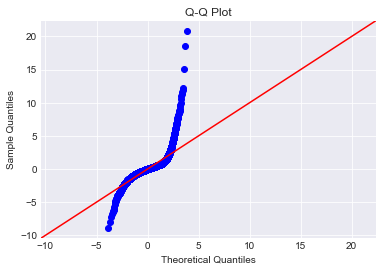

In [5]:
predictors = '+'.join(train.columns[1:])
formula = 'price' + '~' + predictors
model = ols(formula=formula, data=train).fit()
get_model_data(model)

## Removing Outliers

In [6]:
# removing values outside three times the standard diviation
# mean and std taken from EDA notebook
mean = 5.402966e+05
std = 3.673681e+05

upper_cutoff = mean + (3*std)
lower_cutoff = mean - (3*std)

In [7]:
train = train[(train['price'] < upper_cutoff) & (train['price'] > lower_cutoff)]
test = test[(test['price'] < upper_cutoff) & (test['price'] > lower_cutoff)]

R2 = 0.8263781009104862
R2 adjusted = 0.8253117893863833
RMSE (train) = 107820.68718830915
RMSE (test) = 105106.82624209367
number of significant features = 82


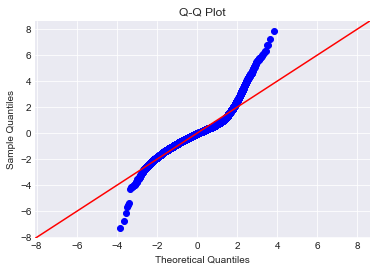

In [8]:
predictors = '+'.join(train.columns[1:])
formula = 'price' + '~' + predictors
model = ols(formula=formula, data=train).fit()
get_model_data(model)

The model looks a lot better after dropping values outside three times the standard deviation. However, now we only have data within three times the standard deviation to work with.

Upper value = 1,642,400

# Log Transforming Continuous Variables

In [9]:
train.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'waterfront', 'sqft_basement', 'lat', 'long', 'yr_since_built',
       'renovated', 'floors_15', 'floors_20', 'floors_25', 'floors_30',
       'floors_35', 'condition_2', 'condition_3', 'condition_4', 'condition_5',
       'grade_11', 'grade_12', 'grade_13', 'grade_3', 'grade_4', 'grade_5',
       'grade_6', 'grade_7', 'grade_8', 'grade_9', 'zipcode_98002',
       'zipcode_98003', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006',
       'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011',
       'zipcode_98014', 'zipcode_98019', 'zipcode_98022', 'zipcode_98023',
       'zipcode_98024', 'zipcode_98027', 'zipcode_98028', 'zipcode_98029',
       'zipcode_98030', 'zipcode_98031', 'zipcode_98032', 'zipcode_98033',
       'zipcode_98034', 'zipcode_98038', 'zipcode_98039', 'zipcode_98040',
       'zipcode_98042', 'zipcode_98045', 'zipcode_98052', 'zipcode_98053',
       'zipcode_98055', 'zipcode_98056',

In [10]:
continuous = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot']
for col in continuous:
    train[col] = train[col].map(np.log)
    test[col] = test[col].map(np.log)

R2 = 0.856656770443301
R2 adjusted = 0.8557764175708811
RMSE (train) = 103018.10407889346
RMSE (test) = 99717.35070794875
number of significant features = 90


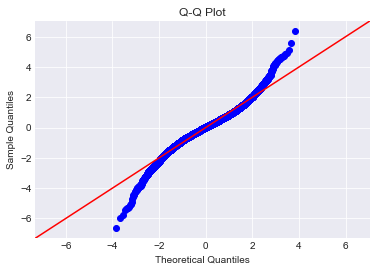

In [11]:
predictors = '+'.join(train.columns[1:])
formula = 'price' + '~' + predictors
model = ols(formula=formula, data=train).fit()
get_model_data(model, True)

## Removing Insignificant Features

In [12]:
model_dict = list(dict(model.pvalues).items())
model_dict.sort(key = lambda x: x[1], reverse=True)
highest_pvalue = model_dict[0]

while highest_pvalue[1] > 0.05:
    
    train.drop(highest_pvalue[0], inplace = True, axis = 1)
    test.drop(highest_pvalue[0], inplace = True, axis = 1)
    
    predictors = '+'.join(train.columns[1:])
    formula = 'price' + '~' + predictors
    model = ols(formula=formula, data=train).fit()

    model_dict = list(dict(model.pvalues).items())
    model_dict.sort(key = lambda x: x[1], reverse=True)
    highest_pvalue = model_dict[0]

R2 = 0.8565983606377625
R2 adjusted = 0.8557998195845525
RMSE (train) = 103090.79095368995
RMSE (test) = 99701.97281892558
number of significant features = 89


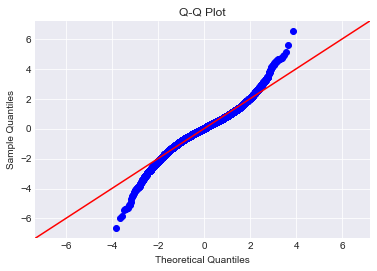

In [13]:
get_model_data(model, True)

In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     1073.
Date:                Sat, 21 Nov 2020   Prob (F-statistic):               0.00
Time:                        13:55:22   Log-Likelihood:                 4484.0
No. Observations:               15892   AIC:                            -8790.
Df Residuals:                   15803   BIC:                            -8107.
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -86.9619      7.303    -11.907      0.000    -101.277     -72.647
bedrooms          -0.0572      0.007     -7.966      0.000      -0.071      -0.043
bathrooms          0.0620      0.007      9.144      0.000       0.049       0.075
sqft_living        0.4834      0.008     58.379      0.000       0.467       0.500
sqft_lot           0.0667      0.002     27.887      0.000       0.062       0.071
waterfront         0.6030      0.025     24.525      0.000       0.555       0.651
sqft_basement  -5.319e-05   4.32e-06    -12.303      0.000   -6.17e-05   -4.47e-05
lat                0.6476      0.068      9.502      0.000       0.514       0.781
long              -0.5282      0.057     -9.220      0.000      -0.640      -0.416
yr_since_built     0.0004   9.36e-05      4.353      0.000       0.000       0.001
renovated          0.0622      0.009      7.130      0.000       0.045       0.079
floors_15          0.0152      0.006      2.636      0.008       0.004       0.026
floors_30         -0.0636      0.010     -6.205      0.000      -0.084      -0.044
condition_2        0.1893      0.046      4.092      0.000       0.099       0.280
condition_3        0.3135      0.044      7.197      0.000       0.228       0.399
condition_4        0.3484      0.044      7.998      0.000       0.263       0.434
condition_5        0.3988      0.044      9.110      0.000       0.313       0.485
grade_11           0.1345      0.014      9.599      0.000       0.107       0.162
grade_12           0.1777      0.038      4.648      0.000       0.103       0.253
grade_4           -0.4158      0.042     -9.830      0.000      -0.499      -0.333
grade_5           -0.4608      0.018    -24.974      0.000      -0.497      -0.425
grade_6           -0.4111      0.011    -36.424      0.000      -0.433      -0.389
grade_7           -0.3327      0.009    -37.202      0.000      -0.350      -0.315
grade_8           -0.2209      0.008    -27.346      0.000      -0.237      -0.205
grade_9           -0.0821      0.008    -10.111      0.000      -0.098      -0.066
zipcode_98004      0.9511      0.025     38.596      0.000       0.903       0.999
zipcode_98005      0.5853      0.027     21.890      0.000       0.533       0.638
zipcode_98006      0.5713      0.021     27.366      0.000       0.530       0.612
zipcode_98007      0.5174      0.028     18.701      0.000       0.463       0.572
zipcode_98008      0.5418      0.026     20.875      0.000       0.491       0.593
zipcode_98010      0.3594      0.027     13.263      0.000       0.306       0.413
zipcode_98011      0.1952      0.033      5.918      0.000       0.131       0.260
zipcode_98014      0.2422      0.040      5.983      0.000       0.163       0.322
zipcode_98019      0.1971      0.038      5.161      0.000       0.122       0.272
zipcode_9802

# Cross Validation

In [15]:
def kfolds(data, k):
    # Force data as pandas DataFrame
    data = pd.DataFrame(data)
    num_observations = len(data)
    fold_size = num_observations//k
    leftovers = num_observations%k
    folds = []
    start_obs = 0
    for fold_n in range(k):
        if fold_n < leftovers:
            #Fold Size will be 1 larger to account for leftovers
            fold = data.iloc[start_obs : start_obs+fold_size+1] 
            start_obs += 1
        else:
            fold = data.iloc[start_obs : start_obs+fold_size] 
        start_obs += fold_size
        folds.append(fold)
            
    return folds

In [16]:
test_errs = []
k=5
folds = kfolds(pd.concat([train, test]).sample(frac=1, random_state=100), k)
for n in range(k):
    # Split in train and test for the fold
    fold_train = pd.concat([fold for i, fold in enumerate(folds) if i!=n])
    fold_test = folds[n]
    # Fit a linear regression model
    predictors = '+'.join(fold_train.columns[1:])
    formula = 'price' + '~' + predictors
    fold_model = ols(formula=formula, data=fold_train).fit()
    #Evaluate Test Errors
    y_hat_fold_test = fold_model.predict(fold_test.drop('price', axis=1))
    y_fold_test = fold_test['price']
    test_errs.append(np.sqrt(mean_squared_error(np.exp(y_fold_test), np.exp(y_hat_fold_test))))
print(test_errs)

[102266.09988319715, 103700.59427772947, 105505.84513263535, 100822.91716877231, 102075.0082236522]


Our cross validation scores are not far off from each other, so we do not have a problem.

# Residual Plots

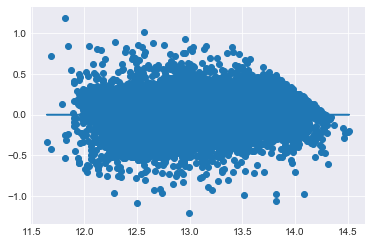

In [17]:
plt.scatter(model.predict(train.drop('price', axis = 1)), model.resid)
plt.plot(model.predict(train.drop('price', axis = 1)), [0 for i in range(len(train))])

Our residuals seem evenly distributed.

In [18]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     1073.
Date:                Sat, 21 Nov 2020   Prob (F-statistic):               0.00
Time:                        13:55:39   Log-Likelihood:                 4484.0
No. Observations:               15892   AIC:                            -8790.
Df Residuals:                   15803   BIC:                            -8107.
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -86.9619      7.303    -11.907      0.000    -101.277     -72.647
bedrooms          -0.0572      0.007     -7.966      0.000      -0.071      -0.043
bathrooms          0.0620      0.007      9.144      0.000       0.049       0.075
sqft_living        0.4834      0.008     58.379      0.000       0.467       0.500
sqft_lot           0.0667      0.002     27.887      0.000       0.062       0.071
waterfront         0.6030      0.025     24.525      0.000       0.555       0.651
sqft_basement  -5.319e-05   4.32e-06    -12.303      0.000   -6.17e-05   -4.47e-05
lat                0.6476      0.068      9.502      0.000       0.514       0.781
long              -0.5282      0.057     -9.220      0.000      -0.640      -0.416
yr_since_built     0.0004   9.36e-05      4.353      0.000       0.000       0.001
renovated          0.0622      0.009      7.130      0.000       0.045       0.079
floors_15          0.0152      0.006      2.636      0.008       0.004       0.026
floors_30         -0.0636      0.010     -6.205      0.000      -0.084      -0.044
condition_2        0.1893      0.046      4.092      0.000       0.099       0.280
condition_3        0.3135      0.044      7.197      0.000       0.228       0.399
condition_4        0.3484      0.044      7.998      0.000       0.263       0.434
condition_5        0.3988      0.044      9.110      0.000       0.313       0.485
grade_11           0.1345      0.014      9.599      0.000       0.107       0.162
grade_12           0.1777      0.038      4.648      0.000       0.103       0.253
grade_4           -0.4158      0.042     -9.830      0.000      -0.499      -0.333
grade_5           -0.4608      0.018    -24.974      0.000      -0.497      -0.425
grade_6           -0.4111      0.011    -36.424      0.000      -0.433      -0.389
grade_7           -0.3327      0.009    -37.202      0.000      -0.350      -0.315
grade_8           -0.2209      0.008    -27.346      0.000      -0.237      -0.205
grade_9           -0.0821      0.008    -10.111      0.000      -0.098      -0.066
zipcode_98004      0.9511      0.025     38.596      0.000       0.903       0.999
zipcode_98005      0.5853      0.027     21.890      0.000       0.533       0.638
zipcode_98006      0.5713      0.021     27.366      0.000       0.530       0.612
zipcode_98007      0.5174      0.028     18.701      0.000       0.463       0.572
zipcode_98008      0.5418      0.026     20.875      0.000       0.491       0.593
zipcode_98010      0.3594      0.027     13.263      0.000       0.306       0.413
zipcode_98011      0.1952      0.033      5.918      0.000       0.131       0.260
zipcode_98014      0.2422      0.040      5.983      0.000       0.163       0.322
zipcode_98019      0.1971      0.038      5.161      0.000       0.122       0.272
zipcode_9802

In [20]:
model.params.to_csv('data/final_model.csv', header=False)